# Machine learning example

In [3]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import seaborn as sns
sns.reset_orig()
from matplotlib import style
style.use("plots.mplstyle")

In [5]:
from pathlib import Path
data_path = "/home/simonpf/data/hydronn/training_data/"
files = list(Path(data_path).glob("*.nc"))
scenes = xr.load_dataset(files[0])
scene = scenes[{"scenes": 244}]

In [6]:
y = scenes.surface_precip.data
x = scenes["C13"].data
mask = y >= 0
x_lr = x[mask]
y_lr = y[mask]

/tmp/ipykernel_29092/4210373480.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(bins[1], bins[0], img, cmap=cmap)
/tmp/ipykernel_29092/4210373480.py:43: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m, label="Counts", cax=ax, orientation="horizontal")
/tmp/ipykernel_29092/4210373480.py:55: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(x.data, cmap="Greys")
/tmp/ipykernel_29092/4210373480.py:56: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(y_ret, cmap=cmap, levels=levels, norm=norm)
/tmp/ipykernel_2909

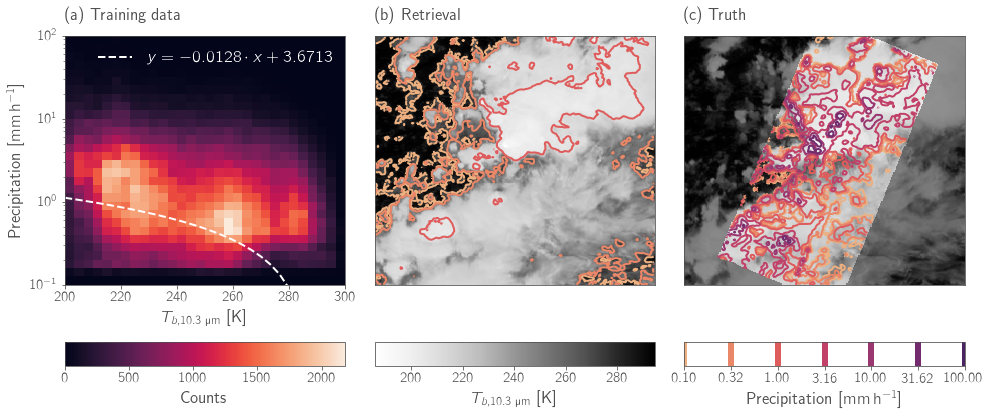

In [7]:
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.cm import get_cmap
from scipy.signal import convolve
from scipy.stats import linregress
from copy import copy

f = plt.figure(figsize=(14, 6))
norm = LogNorm(1e-1, 1e2)
levels = np.logspace(-1, 2, 7)
gs = GridSpec(2, 3, height_ratios=[1.0, 0.1])
axs = [f.add_subplot(gs[0, i]) for i in range(3)]

#
# Linear regression
#

ax = axs[0]

cmap = sns.color_palette("rocket", as_cmap=True)
bins = (np.logspace(-1, 2, 31), np.linspace(200, 300, 31))

img, _, _ = np.histogram2d(y_lr, x_lr, bins=bins)
mask = (y_lr > 0.0) * (x_lr > 0.0)
mask =  (x_lr > 0.0)

r = linregress(x_lr[mask], y_lr[mask])
#y_r = 10 ** (r.slope * bins[1] + r.intercept)
y_r = (r.slope * bins[1] + r.intercept)

m = ax.pcolormesh(bins[1], bins[0], img, cmap=cmap)
label = f"$y = {r.slope:0.4f} \cdot x + {r.intercept:0.4f}$"
ax.plot(bins[1], y_r, c="w", ls="--", label=label)
ax.set_yscale("log")
ax.set_ylim([1e-1, 1e2])
ax.legend(labelcolor="w", fontsize="large")

ax.set_title("(a) Training data", loc="left")
ax.set_xlabel("$T_{b, \SI{10.3}{\micro \meter}}$ [K]")
ax.set_ylabel("Precipitation [$\si{\milli \meter \per \hour}$]")

ax = f.add_subplot(gs[1, 0])
plt.colorbar(m, label="Counts", cax=ax, orientation="horizontal")

#
# Retrieved
#

x = scene["C13"].data
y = scene.surface_precip.data
cmap = copy(sns.color_palette("flare", as_cmap=True))

ax = axs[1]
y_ret = (r.slope * x.data + r.intercept)
m = ax.pcolormesh(x.data, cmap="Greys")
ax.contour(y_ret, cmap=cmap, levels=levels, norm=norm)

ax.set_title("(b) Retrieval", loc="left")
ax.set_xticks([])
ax.set_yticks([])

ax = f.add_subplot(gs[1, 1])
plt.colorbar(m, label="$T_{b, \SI{10.3}{\micro \meter}}$ [K]", cax=ax, orientation="horizontal")

#
# Truth
#

k = np.ones((3, 3)) / 9.0
y_s = convolve(y.data, k, method="direct", mode="same")


cmap = copy(sns.color_palette("flare", as_cmap=True))
cmap.set_bad("#FFFFFF80")

mask_cmap = ListedColormap(["#00000060"])

ax = axs[2]
ax.pcolormesh(x.data, cmap="Greys")
mask = np.isnan(y_s).astype(np.float32)
mask[y_s >= 0] = np.nan
ax.pcolormesh(mask, cmap=mask_cmap)
m = ax.contour(y_s.data, cmap=cmap, levels=levels, norm=norm)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(c) Truth", loc="left")

ax = f.add_subplot(gs[1, 2])
cb = plt.colorbar(m, label="Precipitation [$\si{\milli \meter \per \hour}$]", cax=ax, orientation="horizontal")
for l in cb.lines:
    l.set_linewidth(6)
    
plt.tight_layout()
f.savefig("linear_regression.png", dpi=300, bbox_inches="tight")

## Neural network predictions

### MLP


In [8]:
from quantnn.qrnn import QRNN
from quantnn.normalizer import Normalizer
qrnn = QRNN.load("../mlp.pckl")
normalizer = Normalizer.load("/home/simonpf/src/uncertainty_quantification/data/normalizer_precip_visir.pckl")

In [9]:
from copy import copy
normalizer_0 = copy(qrnn.normalizer)
normalizer_0.stats = {0: qrnn.normalizer.stats[8]}
normalizer_0.feature_axis = 1

In [10]:
x = normalizer_0(scene["C13"].data.reshape(-1, 1))

In [11]:
y_mlp = qrnn.posterior_mean(x).reshape(256, 256)

### Hydronn

In [12]:
from quantnn.qrnn import QRNN
qrnn = QRNN.load("/home/simonpf/src/hydronn/models/hydronn_2.pckl")

In [13]:
from hydronn.data.training_data import HydronnDataset
dataset = HydronnDataset(
    files[0],
    batch_size=1,
    normalize=True,
    normalizer=qrnn.normalizer,
    shuffle=False,
    augment=False
)

In [14]:
import torch
ind = np.where(dataset.indices == 244)[0][0]
x = dataset[ind]
with torch.no_grad():
    y_pred = qrnn._post_process_prediction(y_pred=qrnn.model(x[0]))
    y_h2 = qrnn.posterior_mean(y_pred=y_pred)[0].numpy()

/tmp/ipykernel_29092/4242735490.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(x.data, cmap="Greys")
/tmp/ipykernel_29092/4242735490.py:32: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contourf(y_ret, cmap=cmap, levels=levels, norm=norm)
/tmp/ipykernel_29092/4242735490.py:40: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(m, label="$T_{b, \SI{10.3}{\micro \meter}}$ [K]", cax=ax, orientation="horizontal")
/tmp/ipykernel_29092/4242735490.py:51: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  m = ax.pcolormesh(x.data, cmap="Greys")

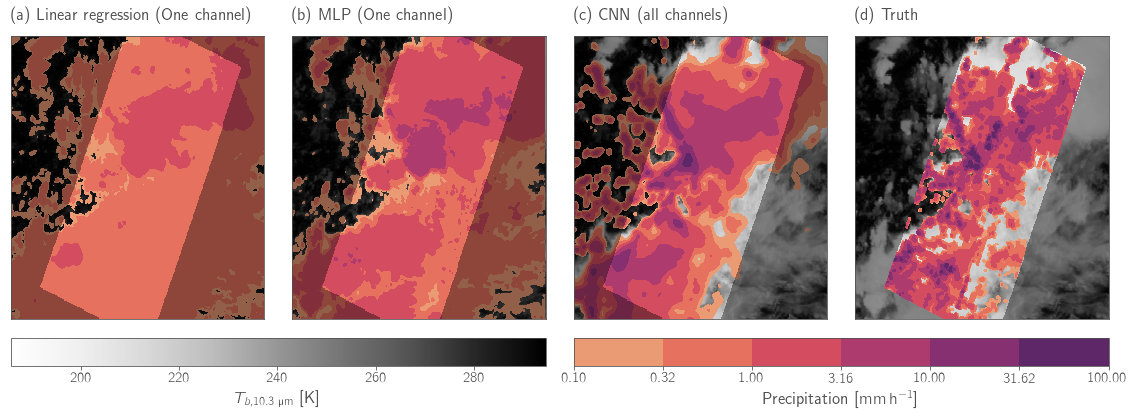

In [15]:
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.cm import get_cmap
from scipy.signal import convolve
from scipy.stats import linregress
from copy import copy

f = plt.figure(figsize=(16, 6))
norm = LogNorm(1e-1, 1e2)
levels = np.logspace(-1, 2, 7)
gs = GridSpec(2, 4, height_ratios=[1.0, 0.1])
axs = [f.add_subplot(gs[0, i]) for i in range(4)]

k = np.ones((2, 2)) / 4.0
y_s = convolve(y.data, k, method="direct", mode="same")
mask_cmap = ListedColormap(["#FFFFFF80"])
mask_cmap = ListedColormap(["#00000060"])
mask = np.isnan(y_s).astype(np.float32)
mask[y_s >= 0] = np.nan

#
# Linear regression
#

x = scene["C13"].data
y = scene.surface_precip.data
cmap = copy(sns.color_palette("flare", as_cmap=True))

ax = axs[0]
y_ret = (r.slope * x.data + r.intercept)
m = ax.pcolormesh(x.data, cmap="Greys")
ax.contourf(y_ret, cmap=cmap, levels=levels, norm=norm)
ax.pcolormesh(mask, cmap=mask_cmap)

ax.set_title("(a) Linear regression (One channel)", loc="left")
ax.set_xticks([])
ax.set_yticks([])

ax = f.add_subplot(gs[1, :2])
plt.colorbar(m, label="$T_{b, \SI{10.3}{\micro \meter}}$ [K]", cax=ax, orientation="horizontal")

#
# MLP
#

x = scene["C13"].data
y = scene.surface_precip.data
cmap = copy(sns.color_palette("flare", as_cmap=True))

ax = axs[1]
m = ax.pcolormesh(x.data, cmap="Greys")
ax.contourf(y_mlp, cmap=cmap, levels=levels, norm=norm)
ax.pcolormesh(mask, cmap=mask_cmap)

ax.set_title("(b) MLP (One channel)", loc="left")
ax.set_xticks([])
ax.set_yticks([])


#
# Hydronn
#

x = scene["C13"].data
y = scene.surface_precip.data
cmap = copy(sns.color_palette("flare", as_cmap=True))

ax = axs[2]
y_ret = (r.slope * x.data + r.intercept)
m = ax.pcolormesh(x.data, cmap="Greys")
ax.contourf(y_h2, cmap=cmap, levels=levels, norm=norm)
ax.pcolormesh(mask, cmap=mask_cmap)

ax.set_title("(c) CNN (all channels)", loc="left")
ax.set_xticks([])
ax.set_yticks([])


#
# Truth
#


cmap = copy(sns.color_palette("flare", as_cmap=True))
cmap.set_bad("#FFFFFF80")

ax = axs[3]
ax.pcolormesh(x.data, cmap="Greys")
ax.pcolormesh(mask, cmap=mask_cmap)
m = ax.contourf(y_s.data, cmap=cmap, levels=levels, norm=norm)
ax.set_xticks([])
ax.set_yticks([])

ax.set_title("(d) Truth", loc="left")

ax = f.add_subplot(gs[1, 2:])
cb = plt.colorbar(m, label="Precipitation [$\si{\milli \meter \per \hour}$]", cax=ax, orientation="horizontal")
for l in cb.lines:
    l.set_linewidth(6)
    
plt.tight_layout()
f.savefig("retrieval_comparison.png", dpi=300, bbox_inches="tight")

In [76]:
x

array([[257.24307125, 253.99407675, 251.85655381, ..., 246.23317533,
        246.28550069, 246.91022941],
       [258.61802632, 254.32091677, 253.00453914, ..., 247.42642874,
        247.63180631, 250.09867104],
       [263.47100659, 257.77831497, 257.6893741 , ..., 249.05230621,
        250.73857853, 253.19408022],
       ...,
       [273.11105548, 270.84137999, 270.95442806, ..., 214.0904951 ,
        213.99754641, 213.15265919],
       [274.78395564, 271.36765246, 271.18007262, ..., 214.27584692,
        213.81109895, 213.34172819],
       [276.21314935, 271.965145  , 271.36765246, ..., 214.0904951 ,
        213.53003869, 213.6239119 ]])

TypeError: Invalid shape (256,) for image data

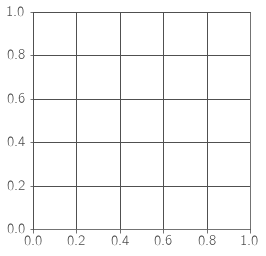

In [74]:
plt.imshow(x[0])

In [ ]:
lines.linewidth: 4
lines.solid_capstyle: butt

legend.fancybox: true

axes.prop_cycle: cycler('color', ['008fd5', 'fc4f30', 'e5ae38', '6d904f', '8b8b8b', '810f7c'])
axes.facecolor: f0f0f0
axes.labelsize: large
axes.axisbelow: true
axes.grid: true
axes.edgecolor: f0f0f0
axes.linewidth: 3.0
axes.titlesize: x-large

patch.edgecolor: f0f0f0
patch.linewidth: 0.5

svg.fonttype: path

grid.linestyle: -
grid.linewidth: 1.0
grid.color: cbcbcb

xtick.major.size: 0
xtick.minor.size: 0
ytick.major.size: 0
ytick.minor.size: 0

font.size:14.0

savefig.edgecolor: f0f0f0
savefig.facecolor: f0f0f0

figure.subplot.left: 0.08
figure.subplot.right: 0.95
figure.subplot.bottom: 0.07
figure.facecolor: f0f0f0